**Problem 2.2:** Basic RAG - Part 1: Document Loading & Splitting  
**Goal:** Load and prepare a document for retrieval.  
**Task:**  
1. Find a short `.txt` file (e.g., news article or short story).  
2. Load it using a LangChain `DocumentLoader` (like `TextLoader`).  
3. Split it into chunks using a `TextSplitter` (like `RecursiveCharacterTextSplitter`).  
4. Print:  
   - Total number of chunks  
   - Content of the first few chunks  
**LangChain:** Use `TextLoader` and `RecursiveCharacterTextSplitter`  
**Check:**  
- Does the document load correctly?  
- Are the chunks meaningful?  
- Did you set `chunk_size` and `chunk_overlap` appropriately?


In [66]:
from dotenv import load_dotenv

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, BaseMessage

from typing import List,Optional, TypedDict, Sequence, Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages

from langgraph.graph import StateGraph,START,END

In [67]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [68]:
load_dotenv()

True

In [69]:
## state definition

class AgentState(TypedDict):
    question : Optional[str]
    doc_text : Optional[str]
    doc_chunks: Optional[List[str]]
    answer : Optional[str]

In [70]:
# ---- Model Binding ----
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest", temperature=0.7
)


In [71]:
def user_query(state: AgentState) -> AgentState:
    """
       doc loader
       and 
       chunker
    """
    
    loader = TextLoader("q.txt")
    documents = loader.load()   
    print("✅ Loaded document:")
    print(documents[0].page_content[:300])    
    
    # chunker part
    
    splitter = RecursiveCharacterTextSplitter(chunk_size = 100 , chunk_overlap = 20)
    chunks = splitter.split_documents(documents=documents)
    
    
    return {"doc_text":documents[0].page_content , "doc_chunks":chunks}

In [72]:
def get_response(state: AgentState) -> AgentState:
    
    """
        prompt our llm with the question and get a response.
    """
    # invoke , stream , batch
    # invoke - input - output
    # stream - cont inp - out 
    # batch send a batch and paralelize them 
    sys_prompt = SystemMessage(content="you are a ai assistant that answers questions in a clear and explanatory way")
    prompt = HumanMessage(content=state['doc_text'])
    response = llm.invoke([sys_prompt, prompt])
    
    # print(response.type)
    # print(prompt.type)
    return {"answer" : response.content}

In [73]:
graph = StateGraph(AgentState)

graph.add_node("prompt", user_query)
graph.add_node("resp", get_response)

graph.add_edge(START,"prompt")
graph.add_edge("prompt", "resp")
graph.add_edge("resp", END)

app = graph.compile()

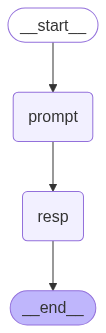

In [74]:
from IPython.display import Image, display
from io import BytesIO

# Get image bytes directly from your graph generator
image_bytes = app.get_graph().draw_mermaid_png()

# Display the image without saving
display(Image(data=image_bytes))


In [76]:
## run agent
state = {"question" : "" ,"doc_text":"", "answer" : ""}
result = app.invoke(state)
print(result["doc_chunks"])

✅ Loaded document:
<<DOCUMENT_START>>
<<PAGE_1>>
<<HEADING level=1>>Welding of Pipelines and Related
Facilities<<HEADING_END>>
<<HEADING level=2>>API STANDARD 1104
TWENTY-FIRST EDITION, SEPTEMBER 2013<<HEADING_END>>
<<HEADING level=2>>ERRATA 1, APRIL 2014
ERRATA 2, JUNE 2014
ERRATA 3, JULY 2014
ERRATA 4, NOVEMBER 2015
[Document(metadata={'source': 'q.txt'}, page_content='<<DOCUMENT_START>>\n<<PAGE_1>>\n<<HEADING level=1>>Welding of Pipelines and Related'), Document(metadata={'source': 'q.txt'}, page_content='Facilities<<HEADING_END>>\n<<HEADING level=2>>API STANDARD 1104'), Document(metadata={'source': 'q.txt'}, page_content='TWENTY-FIRST EDITION, SEPTEMBER 2013<<HEADING_END>>\n<<HEADING level=2>>ERRATA 1, APRIL 2014'), Document(metadata={'source': 'q.txt'}, page_content='ERRATA 2, JUNE 2014\nERRATA 3, JULY 2014\nERRATA 4, NOVEMBER 2015\nADDENDUM 1, JULY 2014'), Document(metadata={'source': 'q.txt'}, page_content='ADDENDUM 2, MAY 2016<<HEADING_END>>\n<<PAGE_END>>\n<<PAGE_2>>'), Documen